Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')
##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166


Mounted at /content/gdrive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("gdrive/My Drive/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/CNN_assignment/Dataset/Train")
data_dir_test = pathlib.Path("gdrive/My Drive/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/CNN_assignment/Dataset/Test")

In [33]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [5]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [6]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
data_dir = 'gdrive/My Drive/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/CNN_assignment/Dataset/Train'
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [7]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [12]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

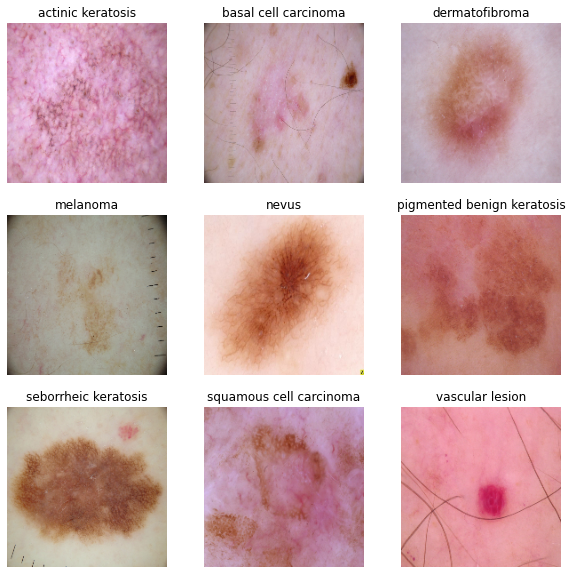

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for i in range(len(class_names)):
    filtered_ds = train_ds.filter(lambda x, l: tf.math.equal(l[0], i))
    for image, label in filtered_ds.take(1):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(image[0].numpy().astype('uint8'))
        plt.title(class_names[label.numpy()[0]])
        plt.axis('off')

In [38]:
import glob
train_image_names = glob.glob('gdrive/My Drive/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/CNN_assignment/Dataset/Train/*/*.jpg')
print("Total number of training images: ", len(train_image_names))

# make train_image_names as serie object
train_image_names = pd.Series(train_image_names)

# train_df: a dataframe with 2 field: Filename, ClassId
traindir_df = pd.DataFrame()

# generate Filename field
traindir_df['Filename'] = train_image_names.map(lambda img_name: img_name.split("/")[-1])

# generate ClassId field
traindir_df['Label'] = train_image_names.map(lambda img_name: img_name.split("/")[-2])

traindir_df.groupby(['Label']) ['Filename'].count()

Total number of training images:  2239


Label
actinic keratosis             114
basal cell carcinoma          376
dermatofibroma                 95
melanoma                      438
nevus                         357
pigmented benign keratosis    462
seborrheic keratosis           77
squamous cell carcinoma       181
vascular lesion               139
Name: Filename, dtype: int64

In [39]:
Label_id_distribution = traindir_df['Label'].value_counts()
Label_id_distribution.head(10)

pigmented benign keratosis    462
melanoma                      438
basal cell carcinoma          376
nevus                         357
squamous cell carcinoma       181
vascular lesion               139
actinic keratosis             114
dermatofibroma                 95
seborrheic keratosis           77
Name: Label, dtype: int64

<BarContainer object of 9 artists>

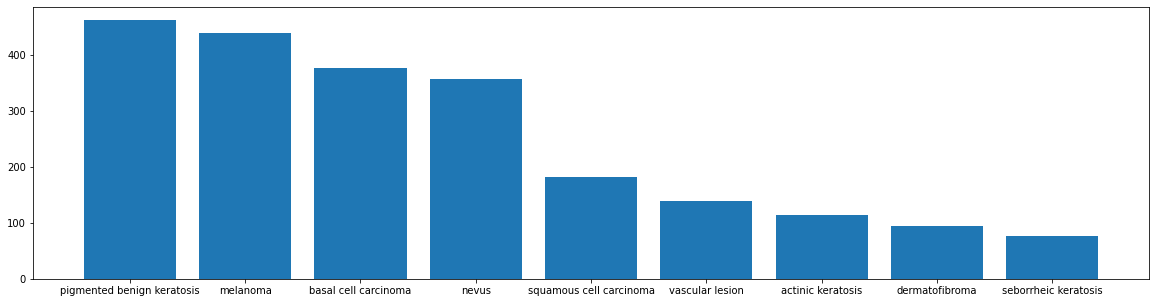

In [40]:
plt.figure(figsize=(20,5))
plt.xticks(np.arange(43))
plt.bar(Label_id_distribution.index, Label_id_distribution.values)

In [41]:
#checking shapes 
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [21]:
### Your code goes here
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Now you cannotice the pixels values are now in range (0,1).
print(np.min(first_image), np.max(first_image)) 


0.17450981 0.97091514


In [22]:
num_classes = 9

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [23]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [24]:
# View the summary of all layers
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_3 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 22, 22, 64)       

### Train the model

In [ ]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
59/59 [==============================] - 76s 809ms/step - loss: 1.9389 - accuracy: 0.2836 - val_loss: 1.7257 - val_accuracy: 0.3582
Epoch 2/20
59/59 [==============================] - 2s 42ms/step - loss: 1.5901 - accuracy: 0.4355 - val_loss: 1.5494 - val_accuracy: 0.4478
Epoch 3/20
59/59 [==============================] - 2s 42ms/step - loss: 1.4089 - accuracy: 0.5144 - val_loss: 1.5423 - val_accuracy: 0.4755
Epoch 4/20
59/59 [==============================] - 2s 41ms/step - loss: 1.3092 - accuracy: 0.5421 - val_loss: 1.3740 - val_accuracy: 0.5330
Epoch 5/20
59/59 [==============================] - 2s 42ms/step - loss: 1.1925 - accuracy: 0.5800 - val_loss: 1.5177 - val_accuracy: 0.4627
Epoch 6/20
59/59 [==============================] - 2s 42ms/step - loss: 1.1578 - accuracy: 0.5906 - val_loss: 1.4451 - val_accuracy: 0.5352
Epoch 7/20
59/59 [==============================] - 2s 42ms/step - loss: 1.0773 - accuracy: 0.6109 - val_loss: 1.3659 - val_accuracy: 0.5522
Epoch 8/20


### Visualizing training results

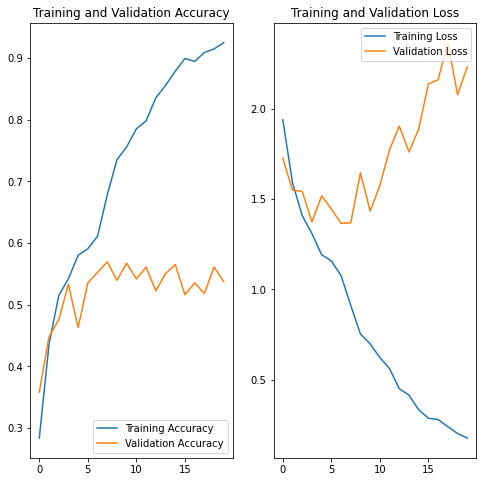

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here
**Observation**: Model Training Accuracy is high and Validation Accuracy is low, it is sign of "Overfiting". Loss at validation is very high compared to Training. We can also see training accuracy is increasing linearly over time, but Validation Accuracy swings and finally drops eventually.

In [ ]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Your code goes here


In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

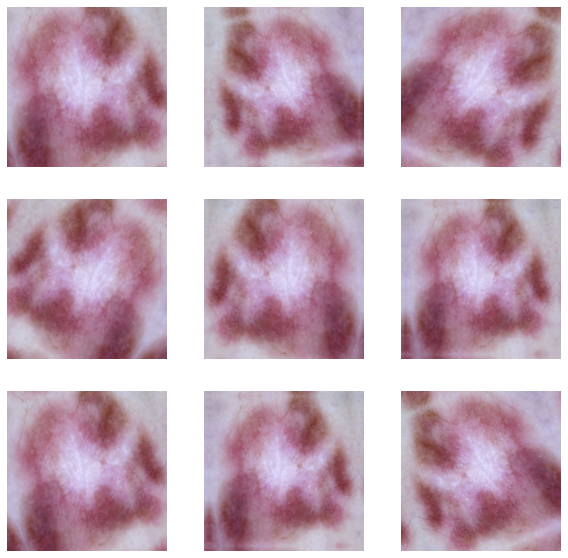

In [ ]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [ ]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])


### Compiling the model

In [ ]:
## Your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training the model

In [ ]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
59/59 [==============================] - 73s 1s/step - loss: 2.6370 - accuracy: 0.1828 - val_loss: 2.1488 - val_accuracy: 0.1727
Epoch 2/20
59/59 [==============================] - 71s 1s/step - loss: 2.0516 - accuracy: 0.1844 - val_loss: 2.1007 - val_accuracy: 0.1770
Epoch 3/20
59/59 [==============================] - 71s 1s/step - loss: 2.0283 - accuracy: 0.2175 - val_loss: 2.0590 - val_accuracy: 0.2601
Epoch 4/20
59/59 [==============================] - 71s 1s/step - loss: 1.9921 - accuracy: 0.2612 - val_loss: 1.9864 - val_accuracy: 0.2495
Epoch 5/20
59/59 [==============================] - 71s 1s/step - loss: 1.9500 - accuracy: 0.2665 - val_loss: 1.9296 - val_accuracy: 0.2687
Epoch 6/20
59/59 [==============================] - 71s 1s/step - loss: 1.8438 - accuracy: 0.3241 - val_loss: 1.7995 - val_accuracy: 0.3603
Epoch 7/20
59/59 [==============================] - 71s 1s/step - loss: 1.6360 - accuracy: 0.4083 - val_loss: 1.6941 - val_accuracy: 0.4200
Epoch 8/20
59/59 [==

### Visualizing the results

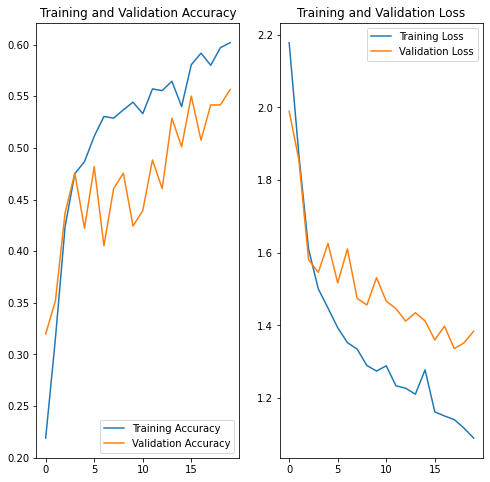

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

**Observations**: Model Training Accuracy and Validation Accuracy are  close to each other, say definately no overfitting. We can try improving the over all model performance by rectifying class imbalance.

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [42]:
## Your code goes here.
import glob
train_image_names = glob.glob('gdrive/My Drive/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/CNN_assignment/Dataset/Train/*/*.jpg')
print("Total number of training images: ", len(train_image_names))

# make train_image_names as serie object
train_image_names = pd.Series(train_image_names)

# train_df: a dataframe with 2 field: Filename, ClassId
traindir_df = pd.DataFrame()

# generate Filename field
traindir_df['Filename'] = train_image_names.map(lambda img_name: img_name.split("/")[-1])

# generate ClassId field
traindir_df['Label'] = train_image_names.map(lambda img_name: img_name.split("/")[-2])

traindir_df.head()


Total number of training images:  2239


,Filename,Label
0,ISIC_0025244.jpg,vascular lesion
1,ISIC_0025197.jpg,vascular lesion
2,ISIC_0024904.jpg,vascular lesion
3,ISIC_0024867.jpg,vascular lesion
4,ISIC_0024747.jpg,vascular lesion


In [43]:
traindir_df.groupby(['Label']) ['Filename'].count()


Label
actinic keratosis             114
basal cell carcinoma          376
dermatofibroma                 95
melanoma                      438
nevus                         357
pigmented benign keratosis    462
seborrheic keratosis           77
squamous cell carcinoma       181
vascular lesion               139
Name: Filename, dtype: int64

In [52]:
# % of proposition images compared to grouped catergory
traindir_df.groupby(['Label']) ['Filename'].count()/traindir_df.shape[0]

Label
actinic keratosis             0.050916
basal cell carcinoma          0.167932
dermatofibroma                0.042430
melanoma                      0.195623
nevus                         0.159446
pigmented benign keratosis    0.206342
seborrheic keratosis          0.034390
squamous cell carcinoma       0.080840
vascular lesion               0.062081
Name: Filename, dtype: float64

#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples? 
**Observation**: Class "seborrheic keratosis" is least number of samples.
#### - Which classes dominate the data in terms proportionate number of samples? 
**Observation**: Class "pigmented benign keratosis" is dominating.


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [10]:
pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [14]:
import Augmentor
path_to_training_dataset='gdrive/My Drive/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/CNN_assignment/Dataset/Train/'
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to gdrive/My Drive/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/CNN_assignment/Dataset/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F06B00F0E10>: 100%|██████████| 500/500 [00:23<00:00, 21.43 Samples/s]


Initialised with 376 image(s) found.
Output directory set to gdrive/My Drive/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/CNN_assignment/Dataset/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F06B00E3E90>: 100%|██████████| 500/500 [00:23<00:00, 21.03 Samples/s]


Initialised with 95 image(s) found.
Output directory set to gdrive/My Drive/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/CNN_assignment/Dataset/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F06B00F07D0>: 100%|██████████| 500/500 [00:23<00:00, 21.23 Samples/s]


Initialised with 438 image(s) found.
Output directory set to gdrive/My Drive/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/CNN_assignment/Dataset/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F06B0055E50>: 100%|██████████| 500/500 [01:46<00:00,  4.71 Samples/s]


Initialised with 357 image(s) found.
Output directory set to gdrive/My Drive/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/CNN_assignment/Dataset/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=919x802 at 0x7F06B015EDD0>: 100%|██████████| 500/500 [01:34<00:00,  5.27 Samples/s]


Initialised with 462 image(s) found.
Output directory set to gdrive/My Drive/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/CNN_assignment/Dataset/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F06767DA7D0>: 100%|██████████| 500/500 [00:22<00:00, 21.76 Samples/s]


Initialised with 77 image(s) found.
Output directory set to gdrive/My Drive/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/CNN_assignment/Dataset/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F06B00895D0>: 100%|██████████| 500/500 [00:48<00:00, 10.38 Samples/s]


Initialised with 181 image(s) found.
Output directory set to gdrive/My Drive/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/CNN_assignment/Dataset/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F06B0068B50>: 100%|██████████| 500/500 [00:22<00:00, 21.85 Samples/s]


Initialised with 139 image(s) found.
Output directory set to gdrive/My Drive/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/CNN_assignment/Dataset/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F0676729510>: 100%|██████████| 500/500 [00:21<00:00, 22.84 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [15]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [16]:
import glob
train_image_names_new = glob.glob('gdrive/My Drive/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/CNN_assignment/Dataset/Train/*/output/*.jpg')
print("Total number of training images: ", len(train_image_names_new))

# make train_image_names as serie object
train_image_names_new = pd.Series(train_image_names_new)

# train_df: a dataframe with 2 field: Filename, ClassId
traindir_df_new = pd.DataFrame()

# generate Filename field
traindir_df_new['Filename'] = train_image_names_new.map(lambda img_name: img_name.split("/")[-1])

# generate ClassId field
traindir_df_new['Label'] = train_image_names_new.map(lambda img_name: img_name.split("/")[-3])

traindir_df_new.groupby(['Label']) ['Filename'].count()

Total number of training images:  4500


Label
actinic keratosis             500
basal cell carcinoma          500
dermatofibroma                500
melanoma                      500
nevus                         500
pigmented benign keratosis    500
seborrheic keratosis          500
squamous cell carcinoma       500
vascular lesion               500
Name: Filename, dtype: int64

<BarContainer object of 9 artists>

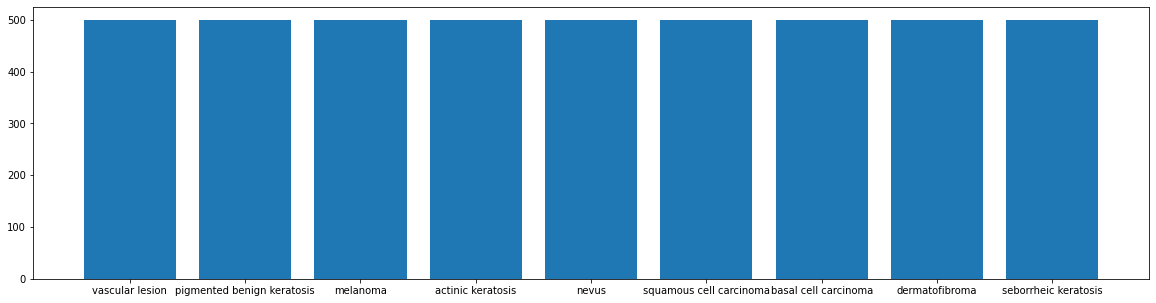

In [17]:
Label_id_distribution = traindir_df_new['Label'].value_counts()
plt.figure(figsize=(20,5))
plt.xticks(np.arange(43))
plt.bar(Label_id_distribution.index, Label_id_distribution.values)

In [21]:
#path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
#path_list

In [ ]:
#lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
#lesion_list_new

In [ ]:
#dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [ ]:
#df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
#new_df = original_df.append(df2)

In [ ]:
#new_df['Label'].value_counts()

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [18]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [19]:
data_dir_train="gdrive/My Drive/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/CNN_assignment/Dataset/Train/"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [20]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [27]:
## your code goes here
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Now you cannotice the pixels values are now in range (0,1).
print(np.min(first_image), np.max(first_image)) 

0.10539187 0.80147046


In [23]:
num_classes = 9

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [24]:
## your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 45, 45, 32)        0

#### **Todo:**  Train your model

In [31]:
# Let's try with 20 epochs first.
epochs = 20
## Your code goes here, use 50 epochs.
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
172/172 [==============================] - 37s 208ms/step - loss: 1.9486 - accuracy: 0.2577 - val_loss: 1.5055 - val_accuracy: 0.4405
Epoch 2/20
172/172 [==============================] - 38s 213ms/step - loss: 1.4395 - accuracy: 0.4449 - val_loss: 1.4088 - val_accuracy: 0.4529
Epoch 3/20
172/172 [==============================] - 38s 214ms/step - loss: 1.2119 - accuracy: 0.5497 - val_loss: 1.1703 - val_accuracy: 0.5676
Epoch 4/20
172/172 [==============================] - 37s 208ms/step - loss: 0.9783 - accuracy: 0.6454 - val_loss: 1.0408 - val_accuracy: 0.6282
Epoch 5/20
172/172 [==============================] - 37s 209ms/step - loss: 0.8034 - accuracy: 0.7089 - val_loss: 0.9362 - val_accuracy: 0.6779
Epoch 6/20
172/172 [==============================] - 38s 213ms/step - loss: 0.6796 - accuracy: 0.7608 - val_loss: 0.9254 - val_accuracy: 0.7093
Epoch 7/20
172/172 [==============================] - 37s 210ms/step - loss: 0.5407 - accuracy: 0.8121 - val_loss: 0.9343 - val_ac

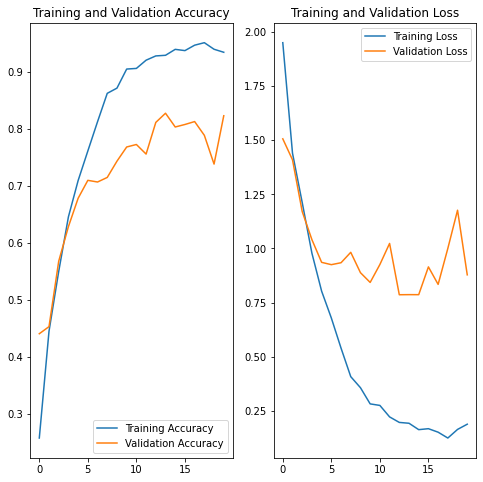

In [32]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [20]:
## Your code goes here, use 50 epochs.
epochs = 50
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
172/172 [==============================] - 39s 213ms/step - loss: 2.1148 - accuracy: 0.1793 - val_loss: 1.9182 - val_accuracy: 0.2798
Epoch 2/50
172/172 [==============================] - 37s 210ms/step - loss: 1.5818 - accuracy: 0.4030 - val_loss: 1.4124 - val_accuracy: 0.4602
Epoch 3/50
172/172 [==============================] - 37s 207ms/step - loss: 1.3069 - accuracy: 0.5141 - val_loss: 1.2464 - val_accuracy: 0.5332
Epoch 4/50
172/172 [==============================] - 36s 204ms/step - loss: 1.1199 - accuracy: 0.5926 - val_loss: 1.1229 - val_accuracy: 0.6041
Epoch 5/50
172/172 [==============================] - 36s 201ms/step - loss: 0.9540 - accuracy: 0.6549 - val_loss: 1.1889 - val_accuracy: 0.5763
Epoch 6/50
172/172 [==============================] - 36s 202ms/step - loss: 0.8707 - accuracy: 0.6930 - val_loss: 1.0750 - val_accuracy: 0.6238
Epoch 7/50
172/172 [==============================] - 36s 204ms/step - loss: 0.7559 - accuracy: 0.7325 - val_loss: 0.9906 - val_ac

#### **Todo:**  Visualize the model results

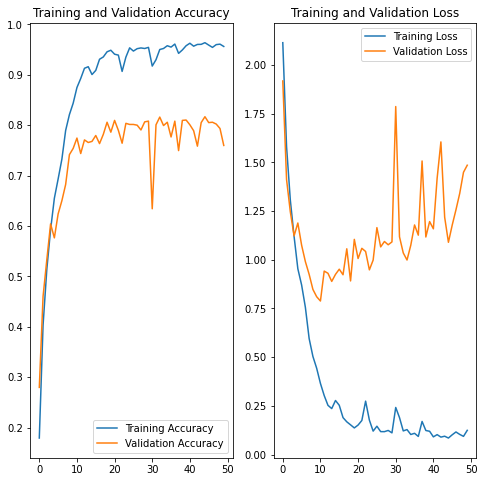

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



**Observation**: Data Augmentation diffiently helped to handle class imbalance and avoid overfitting. We also see, as number of epochs increases the validation accurancy drops. 